### Dependencies & Prerequisites


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
tfd = tfp.distributions
tfpl = tfp.layers
%matplotlib inline

### GPU Acceleration

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Dataset

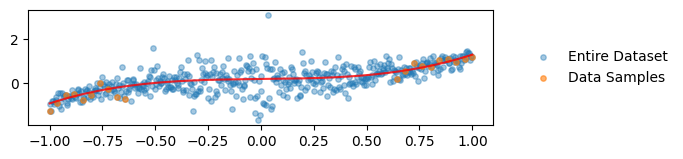

In [3]:
def load_dataset(n=500, ns=20):
  np.random.seed(55)
  x = np.linspace(-1, 1, n)
  y = np.power(x, 3) + 0.1 * (2 + x) + np.random.normal(0, (0.25/((np.abs(x)+0.25))), n)
  rnd_idx = np.random.choice(len(x), ns, replace=False)
  det_idx = np.asarray([0,9,19,29,39,49,59,69,79,89,-90,-80,-70,-60,-50,-40,-30,-20,-10,-1])
  xs = x[det_idx]
  ys = y[det_idx]
  x = x[..., np.newaxis]
  xs = xs[..., np.newaxis]
  return x, y, xs, ys

x, y, xs, ys = load_dataset()

# Set figure size
plt.figure(figsize=(6, 1.5))
# Plot data
plt.plot(x, np.power(x, 3) + 0.1 * (2 + x), color='red', alpha=0.8)
plt.scatter(x, y, s=15, label="Entire Dataset", alpha=0.4)
plt.scatter(xs, ys, s=15, label="Data Samples", alpha=0.6)
# Add legend and show the plot
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

### BNN Model

In [4]:
# Define the negative log-likelihood function.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [5]:
# Define the variational posterior weight distribution -- Multivariate Gaussian.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [6]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

In [7]:
# Build model.
model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1, ),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x.shape[0]),
    tfpl.IndependentNormal(1)
])

# Compile model.
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.005), loss=negloglik)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [8]:
def fit_model(iter, model, xs, ys, epochs=1000, verbose=False):
    # Fit model.
    model.fit(xs, ys, epochs=epochs, verbose=verbose);

    # Visualize model predictions with uncertainty.
    yhats = [model(x) for _ in range(100)];
    avgm = np.zeros_like(x[..., 0]);
    means = [];

    plt.figure(figsize=[6, 1.5]); # inches
    plt.clf();
    plt.scatter(x, y, s=15, label="Entire Dataset", alpha=0.4);
    plt.scatter(xs, ys, s=15, label="Data Samples", alpha=0.6);
    plt.scatter(x, yhats[0].sample(), s=15, label="Model Predictions", alpha=0.4);

    # Aleotoric uncertainty
    yhat = yhats[0];
    mu = np.squeeze(yhat.mean());
    sigma = np.squeeze(yhat.stddev());
    data = x.copy()
    plt.fill_between(data.reshape(data.shape[0]), mu-2*sigma, mu+2*sigma, color='lawngreen', label='$\mu\pm2\sigma$', alpha=0.3);

    for i, yhat in enumerate(yhats):
        m = np.squeeze(yhat.mean());
        s = np.squeeze(yhat.stddev());
        plt.plot(x, m, 'r', label='Ensemble $\mu_i$' if i == 0 else None, linewidth=0.5, alpha=0.2);
        avgm += m;
        means.append(m);
    plt.plot(x, avgm/len(yhats), 'k', label='Overall $\mu$', linewidth=4, alpha=0.5);

    # plt.ylim(-0.,17);
    # plt.yticks(np.linspace(0, 15, 4)[1:]);
    # plt.xticks(np.linspace(*x_range, num=9));

    if iter !=0:
        plt.scatter(xs[-1], ys[-1], s=30, marker='*', color='m', label="New Sample", alpha=1.0);

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom');
    ax.yaxis.set_ticks_position('left');
    ax.spines['left'].set_position(('data', 0));
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));
    plt.title("Iteration {}".format(iter+1))

    return means;

### Active Sampling

New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (-1.0, -1.224746222926799)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (-1.0, -1.224746222926799)
New Sample (x, y): (-0.002004008016032177, 0.32205182830635265)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (-1.0, -1.224746222926799)
New Sample (x, y): (-1.0, -1.224746222926799)
New Sample (x, y): (1.0, 1.1807757207104634)
New Sample (x, y): (-1.0, -1.224746222926799)
New Sample (x, y): (-0.07414829659318645, 0.15294126292355487)
New Sample (x, y): (-0.21042084168336683, 0.45473795624903346)
New Sample (x, y): (-0.22244488977955923, 0.7609848642297179)
New Sample (x, y): (-1.0, -1.224746222926799)
New Sample (x, y): (-1.0, -1.224746222926799)


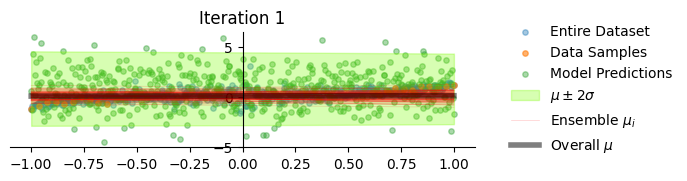

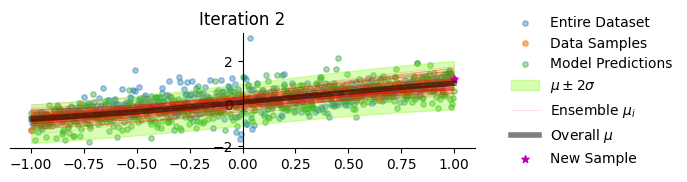

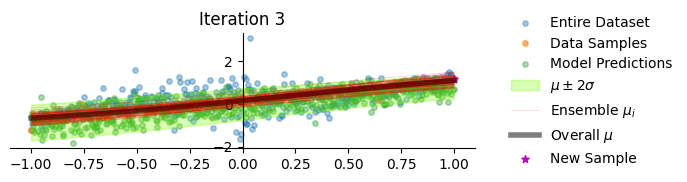

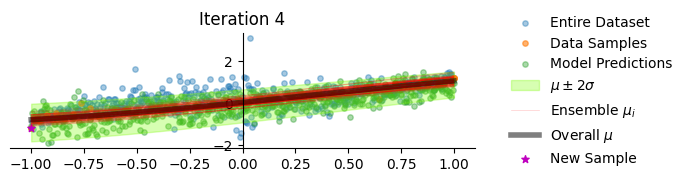

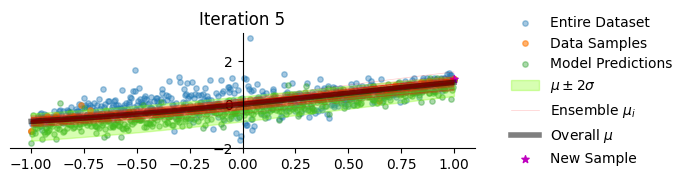

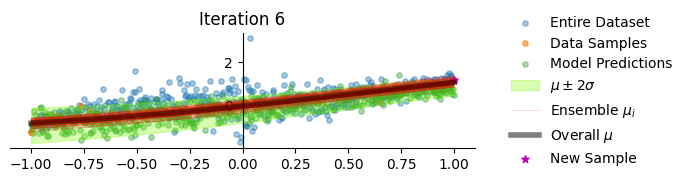

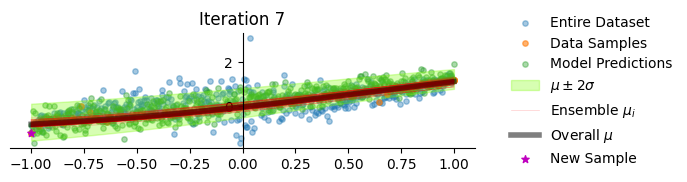

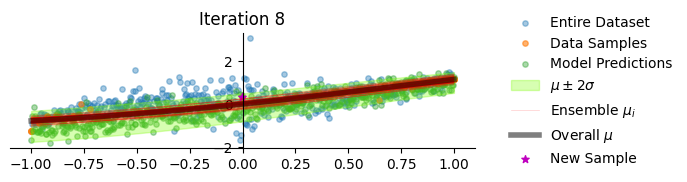

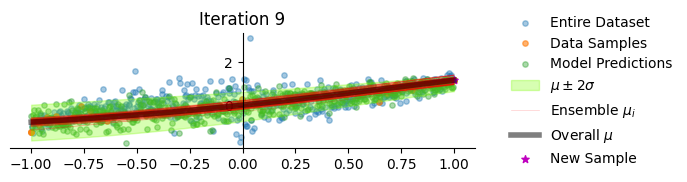

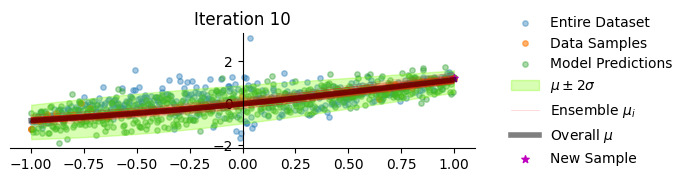

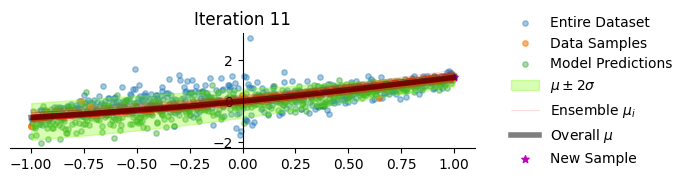

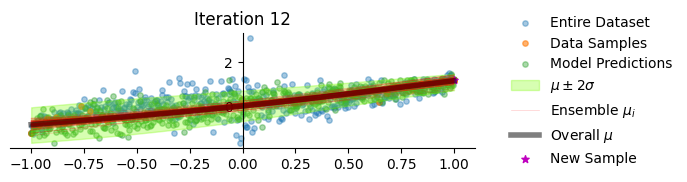

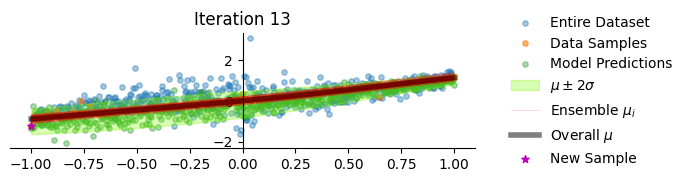

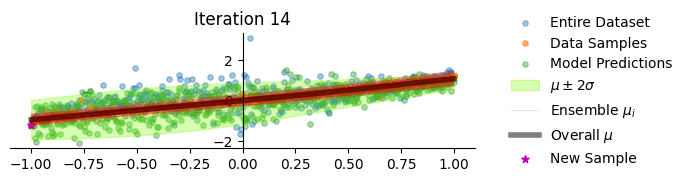

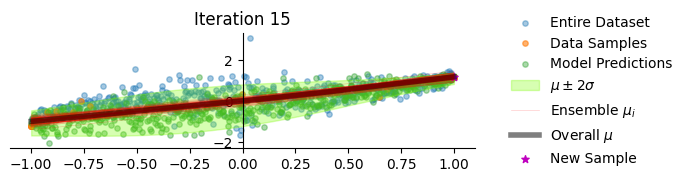

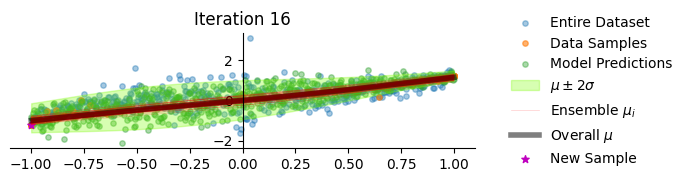

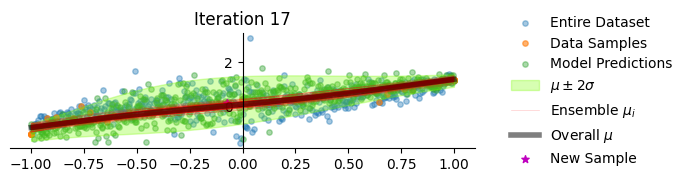

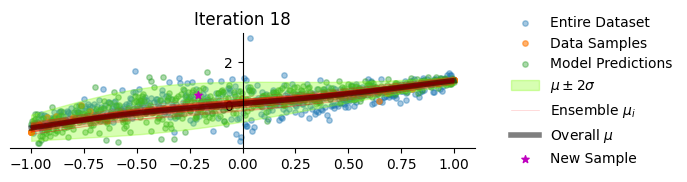

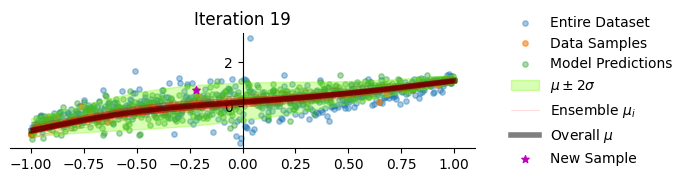

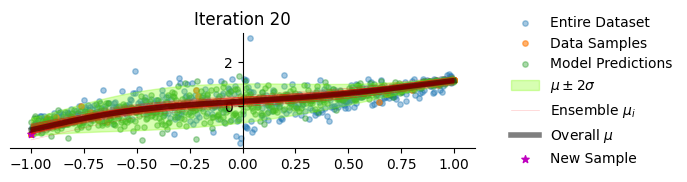

In [9]:
for i in range(20):
    means = fit_model(i, model, xs, ys, epochs=1000, verbose=False); # Train BNN model and visualize predictions
    a = np.std(np.asarray(means), axis=0); # Acquisition function (max epistemic uncertainty)
    next_i = np.where(a == max(a))[0][0]; # Sample index based on acquisition function
    xs = np.append(xs, x[next_i]).reshape(xs.shape[0]+1,1); # Add next sample to XS and reshape the resulting flattened array
    ys = np.append(ys, y[next_i]); # Add next sample to YS
    print("New Sample (x, y): ({}, {})".format(xs[-1][0], ys[-1]))

### Analysis

Epistemic Uncertainty

In [10]:
a = np.std(np.asarray(means), axis=0); # Get epistemic uncertainty over all data points
eu = max(a); # Get maximum epistemic uncertainty
eu

0.12424073

Coverage Probability

In [11]:
CP = 0
n_sim = 1000

x_t, y_t, xs_t, ys_t = load_dataset(n=100, ns=25)

for _ in range(n_sim):
    # Predict
    y_model = model(x_t)
    y_hat = y_model.mean()
    # Coverage probability
    md = np.mean(y_t) - np.mean(y_hat) # Mean deviation of predictions from truth
    se = np.sqrt(np.var(y_t)/len(y_t) + np.var(y_hat)/len(y_hat)) # Standard error between predictions and truth
    if (md - 2*se < 0) and (md + 2*se > 0): # Check whether the interval contains the true value
        CP += 1
CP /= n_sim
print("Coverage Probability for 95% CI: {}".format(CP))

Coverage Probability for 95% CI: 0.949


In [12]:
# Create 95% confidence interval for data
conf_interval = st.t.interval(confidence=0.99, df=len(ys_t)-1,
                              loc=np.mean(ys_t),
                              scale=st.sem(ys_t)
                              )

print("95% Confidence Interval for Sample Test Data: ({}, {})".format(conf_interval[0], conf_interval[1]))

95% Confidence Interval for Sample Test Data: (-0.265136268747956, 0.54385248215098)


In [13]:
np.mean(ys_t)

0.139358106701512

In [14]:
ys_model = model(xs_t)
ys_hat = ys_model.mean()
np.mean(ys_hat)

0.23373094

MSE/RMSE/MAE

In [15]:
n = 100
x_gt_clean = np.linspace(-1, 1, n)
y_gt_clean = np.power(x_gt_clean, 3) + 0.1 * (2 + x_gt_clean)
y_gt_model = model(x_gt_clean)
y_gt_hat = y_gt_model.mean()

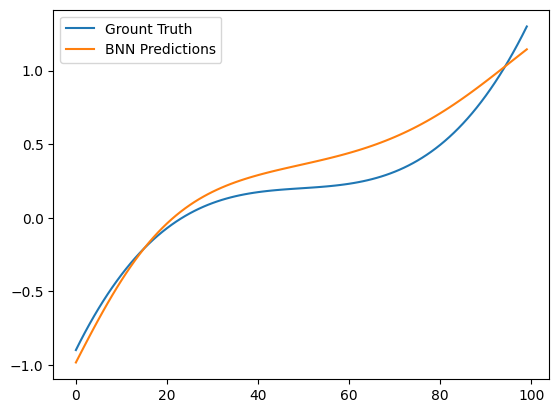

In [16]:
plt.plot(y_gt_clean, label="Grount Truth")
plt.plot(y_gt_hat, label="BNN Predictions")
plt.legend()
plt.show()

In [17]:
mse = (np.square(y_gt_clean - y_gt_hat)).mean()
mse

0.44553646

In [18]:
rmse = np.sqrt((np.square(y_gt_clean - y_gt_hat)).mean())
rmse

0.6674852

In [19]:
mae = (np.abs(y_gt_clean - y_gt_hat)).mean()
mae

0.52983236